In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import acrona, pickle
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

In [4]:
with open('../../Desktop/DLC_social_1/DLC_social_1_exp_conditions.pickle', 'rb') as handle:
    Treatment_dict = pickle.load(handle)

In [26]:
DLC_social_1 = acrona.get_coordinates(path='../../Desktop/DLC_social_1/',#Path where to find the required files
                              p=16,                              #Number of processes used for parallelization
                              smooth_alpha=0,                    #Alpha value for exponentially weighted smoothing
                              distances=False,#['B_Center','B_Nose','B_Left_ear','B_Right_ear','B_Left_flank',
                                         #'B_Right_flank','B_Tail_base'],
                              ego=False,
                              arena='circular',                  #Type of arena used in the experiments
                              arena_dims=[380],                  #Dimensions of the arena. Just one if it's circular
                              video_format='.mp4',
                              table_format='.h5',
                              exp_conditions=Treatment_dict,
                              verbose=True)

In [45]:
DLC_social_1_coords = DLC_social_1.run()

Loading and smoothing trajectories...
Done!


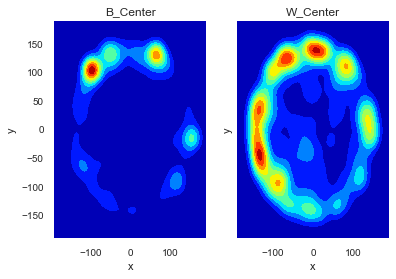

In [28]:
%matplotlib inline
DLC_social_1_coords.plot_heatmaps(bodyparts=['B_Center', 'W_Center'], i=16)

In [ ]:
DLC_social_1_coords.get_coords(center=True, polar=True)

# Angle computing draft 

In [53]:
#Which angles to compute?
bp_net = {'B_Nose':['B_Left_ear','B_Right_ear'],
          'B_Left_ear':['B_Nose','B_Right_ear','B_Center','B_Left_flank'],
          'B_Right_ear':['B_Nose','B_Left_ear','B_Center','B_Right_flank'],
          'B_Center':['B_Left_ear','B_Right_ear','B_Left_flank','B_Right_flank','B_Tail_base'],
          'B_Left_flank':['B_Left_ear','B_Center','B_Tail_base'],
          'B_Right_flank':['B_Right_ear','B_Center','B_Tail_base'],
          'B_Tail_base':['B_Center','B_Left_flank','B_Right_flank']}

In [55]:
import networkx as nx
bp_net = nx.Graph(bp_net)

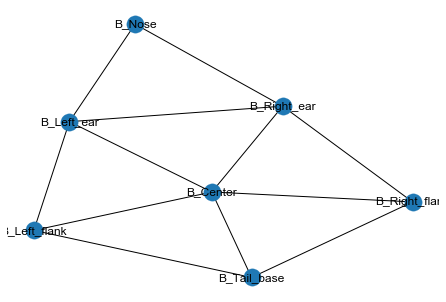

In [67]:
nx.draw(bp_net, with_labels=True)

In [128]:
all_cliques = nx.enumerate_all_cliques(bp_net)
all_cliques = [i for i in all_cliques if len(i) == 3]

In [74]:
import numpy as np

a = np.array([32.49, -39.96])
b = np.array([31.39, -39.28])
c = np.array([31.14, -38.09])


def angle(a,b,c, degrees=False):

    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    
    if degrees:
        return np.degrees(angle)
    
    return angle

In [137]:
def angle_trio(array, degrees=False):
    
    a, b, c = array[:,0], array[:,1], array[:,2]
    
    return np.array([angle(a, b, c, degrees=degrees),
                     angle(a, c, b, degrees=degrees),
                     angle(b, a, c, degrees=degrees)])

In [138]:
example = DLC_social_1_coords.get_coords(center=False, polar=False)['Day2Test13DLC']

In [139]:
%%time
angle_trio(a, b, c, degrees=True)

TypeError: angle_trio() got multiple values for argument 'degrees'

In [140]:
example

bodyparts    B_Center              B_Left_ear             B_Left_flank  \
coords              x           y           x           y            x   
0          319.592438   99.523537  338.146149  122.789108   332.732666   
1          319.330902   99.559776  338.071198  122.996559   332.457001   
2          319.372314   99.387672  338.116943  122.616020   332.615082   
3          319.410950   99.400543  337.980469  122.556374   332.649780   
4          319.420563   99.523071  338.085968  122.848335   332.681244   
...               ...         ...         ...         ...          ...   
14994      311.828674  257.143829  328.506073  273.647217   324.603851   
14995      311.498779  256.593018  328.947937  270.742279   324.271729   
14996      311.905731  257.018188  330.156464  269.460785   324.766113   
14997      312.336212  257.256165  331.092255  268.965607   325.200989   
14998      311.617676  257.127838  331.858215  268.704987   325.360748   

bodyparts                  B_Nose             B_Right_ear              ...  \
coords              y           x           y           x           y  ...   
0          103.230064  338.963074  141.803772  327.386536  131.184784  ...   
1          103.320076  338.961823  141.765945  327.297943  131.295609  ...   
2          103.167618  338.415833  141.883453  327.118805  130.921677  ...   
3          103.295090  338.701874  141.743652  327.081421  130.932663  ...   
4          103.458473  338.729614  141.757370  327.249329  131.220291  ...   
...               ...         ...         ...         ...         ...  ...   
14994      260.623016  333.209564  284.512543  315.772583  282.440613  ...   
14995      259.226013  336.925446  280.935516  317.803680  281.546417  ...   
14996      258.529083  338.854187  280.728363  320.323730  281.711853  ...   
14997      258.147522  339.825745  280.530182  322.264679  280.357758  ...   
14998      258.080688  341.207855  280.338226  323.068970  280.547058  ...   

bodyparts W_Left_flank                  W_Nose             W_Right_ear  \
coords               x           y           x           y           x   
0           269.335846  291.533264  273.197327  254.863998  283.963837   
1           268.353027  295.311401  272.943420  263.887939  285.021729   
2           267.288208  295.112091  273.984192  267.277954  285.609131   
3           266.838501  296.701508  270.273254  265.998901  283.567963   
4           265.856171  296.460846  267.664459  264.452026  281.761230   
...                ...         ...         ...         ...         ...   
14994       126.902496   98.587158   90.790024   79.264046  112.383827   
14995       127.050003   98.736649   90.650505   80.077049  111.737610   
14996       127.561157   99.201218   90.631622   80.194405  112.014099   
14997       127.911232   99.140579   92.134377   79.705688  112.614594   
14998       128.339951   99.184425   92.063820   80.136375  113.432343   

bodyparts             W_Right_flank             W_Tail_base              
coords              y             x           y           x           y  
0          269.447845    291.863770  292.453674  262.768219  329.481293  
1          274.908142    290.317505  298.135773  262.364044  330.235229  
2          278.510590    289.783844  299.782349  262.341919  330.937134  
3          276.802216    290.115204  298.090424  262.479492  331.219116  
4          275.700226    291.158691  292.988800  262.544342  331.166382  
...               ...           ...         ...         ...         ...  
14994       75.428635    131.730911   73.574242  160.257782  102.252457  
14995       75.774254    131.923004   73.655304  160.220261  103.032860  
14996       76.123055    132.079041   74.047050  160.459137  102.986771  
14997       76.119858    132.149536   73.916245  160.176758  103.076004  
14998       76.087959    132.410095   73.728424  159.913055  102.493744  

[14999 rows x 28 columns]

In [141]:
angle_trio(np.array(example[all_cliques[0]]).reshape(14999,3,2))

ValueError: shapes (14999,2) and (14999,2) not aligned: 2 (dim 1) != 14999 (dim 0)